La problématique traitée dans ce code concerne la création d'un modèle de prédiction pour les matchs de football en utilisant des données historiques de matchs et de classements FIFA.

In [122]:
import pandas as pd

pd.options.display.max_columns = None
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from xgboost import XGBClassifier
import mlflow
import datetime
import warnings
warnings.filterwarnings("ignore")

In [17]:
df =  pd.read_csv('C:/Users/hp/Desktop/S5_enetcom/Mlops_project1/data/my_dataset_merge.csv')

In [18]:
import os
os.environ['MLFLOW_TRACKING_USERNAME']= "Youssouf"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "2685You@"

In [121]:
#setup mlflow
mlflow.set_tracking_uri('https://dagshub.com/Youssouf/mlops_project.mlflow') #your mlfow tracking uri
mlflow.set_experiment("youssouf-experiment")

2023/10/08 16:08:29 INFO mlflow.tracking.fluent: Experiment with name 'youssouf-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/4073ddc896b743d5a0f4553ec26d9ce6', creation_time=1696774111461, experiment_id='0', last_update_time=1696774111461, lifecycle_stage='active', name='youssouf-experiment', tags={}>

# Features Engineering
L'idée ici est de créer des fonctionnalités possibles qui ont un impact sur la prédiction des matchs de football. Par intuition, on dit que les features qui impactent pourraient être :

1.   Past game points made
2.   Past goals scored and suffered
3.   The importance of game (friendly or not)
4.   Rank of the teams
5.   Rank increasement of the teams
6.   Goals made and suffered by ranking faced

Donc, la première chose à faire est de créer la fonctionnalité qui indique quelle équipe a gagné et combien de points ils ont gagnés au jeu.


In [22]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [23]:
df[["result", "home_team_points", "away_team_points"]] = results

Les points de jeu sont 3 pour la victoire, 1 pour le match nul et 0 pour la défaite et sont différents des points de classement FIFA qui sont déjà dans la base de données. De plus, il est supposé que les points de classement FIFA et le classement FIFA de la même équipe sont corrélés négativement, et nous ne devrions utiliser qu'un seul d'entre eux pour créer de nouvelles features. Cette supposition est vérifiée ci-dessous :

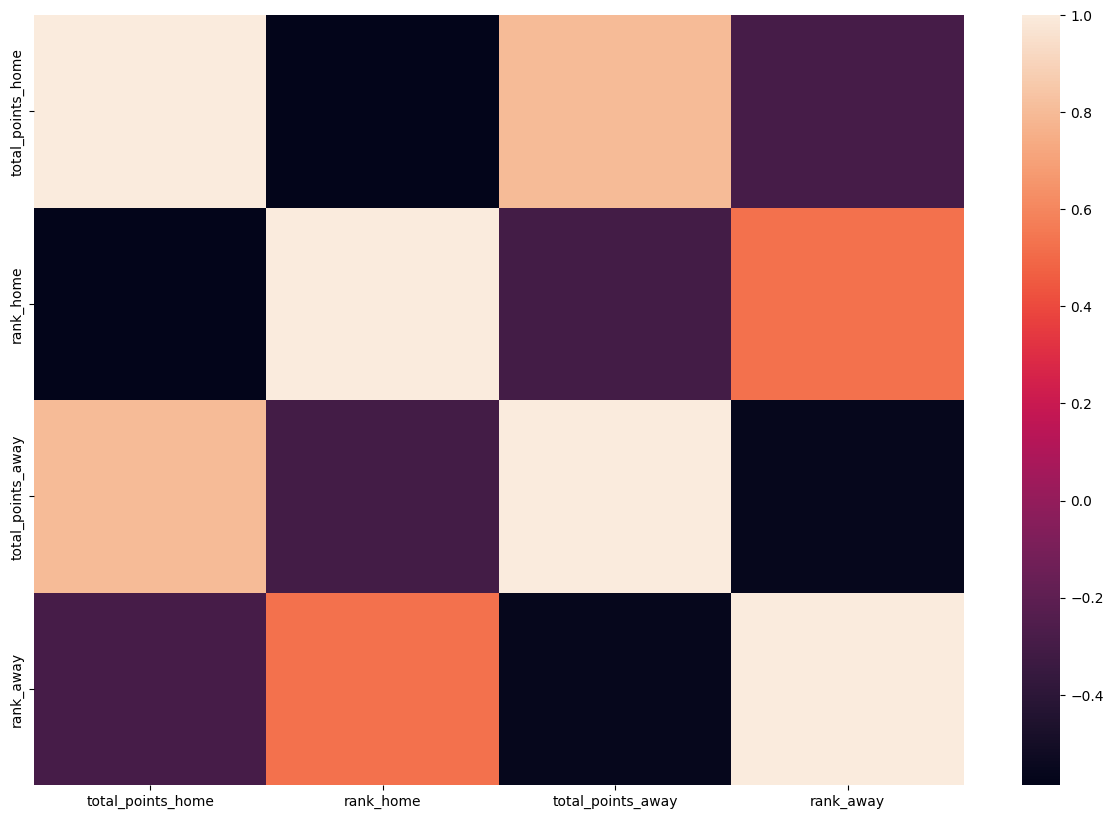

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show()

In [25]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In [26]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [27]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [28]:
team_stats = home_team.append(away_team)#.sort_values("date")

In [29]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
0,2010-08-11,Albania,1,0,70.0,88.0,-1.0,455.00,0,-18.0,0.034091,3
1,2010-08-11,Algeria,1,2,33.0,34.0,0.0,759.00,1,-1.0,0.000000,0
2,2010-08-11,Angola,0,2,87.0,6.0,1.0,357.00,1,81.0,0.000000,0
3,2010-08-11,Armenia,1,3,96.0,65.0,0.0,318.00,1,31.0,0.000000,0
4,2010-08-11,Austria,0,1,60.0,17.0,0.0,536.00,1,43.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9810,2022-09-27,Serbia,2,0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3
9811,2022-09-27,Slovenia,1,1,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1
9812,2022-09-27,Cyprus,1,5,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0
9813,2022-09-27,Northern Ireland,1,3,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0


In [30]:
#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Maintenant, nous avons une base de données prête à créer des caractéristiques prédictives.
Voici les caractéristiques que nous allons calculer :




*   Moyenne des buts marqués par l'équipe lors du cycle de la Coupe du
     Monde.
*   Moyenne des buts marqués par l'équipe lors des 5 derniers matchs.
*   Moyenne des buts encaissés par l'équipe lors du cycle de la Coupe du
     Monde.
*   Moyenne des buts encaissés par l'équipe lors des 5 derniers matchs.
*   Moyenne du classement FIFA de l'adversaire auquel l'équipe a été
     confrontée lors du cycle de la Coupe du Monde.
*   Moyenne du classement FIFA de l'adversaire auquel l'équipe a été
     confrontée lors du cycle de la Coupe du Monde.
*   Points FIFA gagnés lors du cycle de la Coupe du Monde.
*   Points FIFA gagnés lors des 5 derniers matchs.
*   Moyenne des points de jeu lors du cycle de la Coupe du Monde.
*   Moyenne des points de jeu lors des 5 derniers matchs.
*   Moyenne des points de jeu lors des 5 derniers matchs.
*   Moyenne des points de jeu en fonction du classement de l'adversaire  
     lors des 5 derniers matchs.

Ces caractéristiques vous aideront à créer un modèle de prédiction des scores de matchs plus précis en prenant en compte divers aspects de la performance de l'équipe et de l'adversaire.

In [31]:
# Créez une liste vide pour stocker les statistiques calculées
stats_val = []

# Parcourez chaque ligne du DataFrame team_stats
for index, row in team_stats.iterrows():
    # Récupérez le nom de l'équipe et la date du match
    team = row["team"]
    date = row["date"]

    # Sélectionnez tous les matchs passés de l'équipe jusqu'à la date actuelle, triés par date décroissante
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)

    # Sélectionnez les 5 derniers matchs de l'équipe
    last5 = past_games.head(5)

    # Calculez la moyenne des buts marqués par l'équipe pour tous les matchs passés et les 5 derniers matchs
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()

    # Calculez la moyenne des buts encaissés par l'équipe pour tous les matchs passés et les 5 derniers matchs
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()

    # Calculez la moyenne du classement FIFA de l'adversaire pour tous les matchs passés et les 5 derniers matchs
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()

    # Calculez les points FIFA gagnés par l'équipe pour tous les matchs passés et les 5 derniers matchs
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]  # quantité de points gagnés
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1]
    else:
        points = 0
        points_l5 = 0

    # Calculez la moyenne des points de jeu de l'équipe pour tous les matchs passés et les 5 derniers matchs
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()

    # Calculez la moyenne des points de jeu en fonction du classement de l'adversaire pour tous les matchs passés et les 5 derniers matchs
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()

    # Ajoutez les statistiques calculées sous forme de liste à la liste stats_val
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])


In [33]:
# Créez une liste des noms de colonnes pour les statistiques
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

# Créez un DataFrame à partir de la liste de statistiques et des valeurs de statistiques calculées
stats_df = pd.DataFrame(stats_val, columns=stats_cols)

# Réinitialisez l'index du DataFrame team_stats et concaténez-le avec le DataFrame des statistiques
full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [34]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [35]:
home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [36]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [37]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [38]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [39]:
match_stats.head()

,home_goals_mean,home_goals_mean_l5,home_goals_suf_mean,home_goals_suf_mean_l5,home_rank_mean,home_rank_mean_l5,home_points_mean,home_points_mean_l5,home_game_points_mean,home_game_points_mean_l5,...,away_goals_suf_mean,away_goals_suf_mean_l5,away_rank_mean,away_rank_mean_l5,away_points_mean,away_points_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [40]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [41]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'rank_dif', 'sg', 'result', 'home_team_points',
       'away_team_points', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [42]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x))

In [43]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [44]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'rank_dif', 'sg', 'result', 'home_team_points',
       'away_team_points', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [45]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
9810,2022-09-27,Norway,Serbia,36.0,25.0,0,2,1,11.0,0.0,...,1.557377,2.0,0.038259,0.090235,1.576000,2.0,0.041911,0.073887,1,0
9811,2022-09-27,Sweden,Slovenia,20.0,65.0,1,1,2,-45.0,0.0,...,1.671141,0.6,0.067586,0.009231,1.336449,1.0,0.028374,0.029545,1,0
9812,2022-09-27,Kosovo,Cyprus,106.0,108.0,5,1,0,-2.0,0.0,...,1.233333,1.2,0.017072,0.016825,0.693069,1.0,0.012007,0.019652,1,0
9813,2022-09-27,Greece,Northern Ireland,49.0,58.0,3,1,0,-9.0,1.0,...,1.568000,2.4,0.048494,0.028040,1.168142,1.0,0.029230,0.009470,1,0
9814,2022-09-30,Fiji,Solomon Islands,163.0,137.0,1,0,0,26.0,0.0,...,1.260000,1.4,0.007232,0.008868,1.283019,2.0,0.007730,0.012387,1,0


In [46]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                  101
home_goals_mean_l5               101
home_goals_suf_mean              101
home_goals_suf_mean_l5           101
home_rank_mean                   101
home_rank_mean_l5                101
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  100
away_goals_mean_l5               100
away_goals_suf_mean              100
away_goals_suf_mean_l5           100
away_rank_mean                   100
away_rank_mean_l5                100
away_points_mean                   0
away_points_mean_l5                0
h

In [47]:
base_df_no_fg = base_df.dropna()

In [48]:
df = base_df_no_fg

In [49]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x

df["target"] = df["result"].apply(lambda x: no_draw(x))

C:\Users\hp\AppData\Local\Temp\ipykernel_8868\451992140.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["result"].apply(lambda x: no_draw(x))


In [50]:
# Cette fonction prend en entrée un DataFrame df.
def create_db(df):
    # Liste des colonnes que nous voulons inclure dans la base de données résultante.
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]

    # Crée un DataFrame de base en sélectionnant uniquement les colonnes spécifiées.
    base = df.loc[:, columns]

    # Calcule la différence de buts entre l'équipe à domicile et l'équipe à l'extérieur.
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]

    # Calcule la différence de buts encaissés entre l'équipe à domicile et l'équipe à l'extérieur.
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]

    # Calcule la différence de buts par rapport au classement FIFA.
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])

    # Calcule la différence de classement entre l'équipe à domicile et l'équipe à l'extérieur.
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]

    # Calcule la différence de points FIFA entre l'équipe à domicile et l'équipe à l'extérieur.
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]

    # Sélectionne les colonnes finales à inclure dans le modèle.
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]

    # Renvoie le DataFrame résultant.
    return model_df

In [51]:
model_db = create_db(df)

In [130]:
model_db.to_csv('model_db.csv', index=False)

In [52]:
model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
48,Ethiopia,Chad,0,20.0,-1.000000,-1.0,0.000000,0.0,-0.015625,52.000000,52.0,0.000000,0.000000,0,1
51,Algeria,Tanzania,1,-78.0,0.000000,0.0,1.000000,1.0,0.020791,-82.000000,-82.0,-0.008621,-0.008621,1,0
52,Andorra,Russia,1,185.0,-1.000000,-1.0,1.000000,1.0,-0.023256,20.000000,20.0,-0.069767,-0.069767,1,0
53,Armenia,Republic of Ireland,1,60.0,1.000000,1.0,2.000000,2.0,0.015385,60.000000,60.0,0.000000,0.000000,1,0
54,Belgium,Germany,1,44.0,-2.000000,-2.0,-1.000000,-1.0,-0.068966,22.000000,22.0,-0.034483,-0.034483,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9810,Norway,Serbia,1,11.0,-0.078557,-0.8,-0.013246,0.0,-0.005744,8.179082,-3.4,-0.003652,0.016348,1,0
9811,Sweden,Slovenia,1,-45.0,0.300634,0.2,0.029731,0.2,0.012001,-15.983441,10.2,0.039212,-0.020314,1,0
9812,Kosovo,Cyprus,0,-2.0,0.554290,0.6,-0.302475,0.0,0.006341,8.518482,1.6,0.005065,-0.002827,1,0
9813,Greece,Northern Ireland,0,-9.0,0.041699,0.2,-0.342938,-1.2,-0.000579,4.579540,0.6,0.019264,0.018570,1,0


# The model

Maintenant que nous avons une base de données prête et avec des colonnes à pouvoir prédictif, nous pouvons commencer notre modélisation.

Deux modèles seront testés : Random Forest et Gradient Boosting. Le sélectionné sera celui avec le meilleur rappel.

In [53]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [54]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [123]:
method= SMOTE()
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

In [56]:
import numpy as np

In [131]:
version = "v1.0"
data_url = "C:/Users/hp/Desktop/S5_enetcom/Mlops_project1/Notebook/model_db.csv"
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='LogisticRegression'):
    run_id = mlflow.active_run().info.run_id
    mlflow.log_param(f"{run_id}_data_url", data_url)
    mlflow.log_param(f"{run_id}_data_version", version)
    mlflow.log_param(f"{run_id}_input_rows", model_db.shape[0])
    mlflow.log_param(f"{run_id}_input_cols", model_db.shape[1])
    
    # Model fitting and training
    gb = GradientBoostingClassifier(random_state=5)
    
    # Définition d'un dictionnaire de paramètres à tester avec GridSearchCV
    params = {
        "learning_rate": [0.01, 0.1, 0.5],
        "min_samples_split": [5, 10],
        "min_samples_leaf": [3, 5],
        "max_depth": [3, 5, 10],
        "max_features": ["sqrt"],
        "n_estimators": [100, 200]
    }

    # Création d'une instance de GridSearchCV avec le modèle et les paramètres définis
    gb_cv = GridSearchCV(gb, params, cv=3, n_jobs=-1, verbose=False)

    # Ajustement du modèle aux données d'entraînement en utilisant la recherche sur grille
    gb_cv.fit(X_train.values, np.ravel(y_train))

    gb = gb_cv.best_estimator_

    mlflow.set_tag(key="model", value="GradientBoosting")
    params = gb.get_params()
    mlflow.log_params(params)
    gb.fit(X_resampled, y_resampled)
    train_features_name = f'{X_resampled=}'.split('=')[0]
    train_label_name = f'{y_resampled=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name", value=train_features_name)
    mlflow.set_tag(key="train_label_name", value=train_label_name)
    predicted = gb.predict(X_test)
    precision, recall, fscore, support = score(y_test, predicted, average='macro')
    mlflow.log_metric("Precision_test", precision)
    mlflow.log_metric("Recall_test", recall)
    mlflow.log_metric("F1_score_test", fscore)
    mlflow.sklearn.log_model(gb, artifact_path="ML_models")

In [57]:
# Importation du modèle de classification par Gradient Boosting
gb = GradientBoostingClassifier(random_state=5)

# Définition d'un dictionnaire de paramètres à tester avec GridSearchCV
params = {
    "learning_rate": [0.01, 0.1, 0.5],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [3, 5],
    "max_depth": [3, 5, 10],
    "max_features": ["sqrt"],
    "n_estimators": [100, 200]
}

# Création d'une instance de GridSearchCV avec le modèle et les paramètres définis
gb_cv = GridSearchCV(gb, params, cv=3, n_jobs=-1, verbose=False)

# Ajustement du modèle aux données d'entraînement en utilisant la recherche sur grille
gb_cv.fit(X_train.values, np.ravel(y_train))


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [58]:
gb = gb_cv.best_estimator_

In [59]:
gb

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=200, random_state=5)

In [ ]:
gb.fit(X_resampled,y_resampled)
predicted=gb.predict(X_test)


In [ ]:
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

In [134]:

mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='LogisticRegression'):
    run_id0 = mlflow.active_run().info.run_id
    mlflow.log_param(f"{run_id0}_data_url", data_url)
    mlflow.log_param(f"{run_id0}_data_version", version)
    mlflow.log_param(f"{run_id0}_input_rows", model_db.shape[0])
    mlflow.log_param(f"{run_id0}_input_cols", model_db.shape[1])
    
    
    # Définition d'un dictionnaire de paramètres à tester avec GridSearchCV
    params_rf = {
    "max_depth": [20],
    "min_samples_split": [10],
    "max_leaf_nodes": [175],
    "min_samples_leaf": [5],
    "n_estimators": [250],
    "max_features": ["sqrt"],
}

    # Création d'une instance de Random Forest Classifier
    rf = RandomForestClassifier(random_state=1)

    # Création d'une instance de GridSearchCV avec le modèle Random Forest et les paramètres définis
    rf_cv = GridSearchCV(rf, params_rf, cv=3, n_jobs=-1, verbose=False)

    # Ajustement du modèle Random Forest aux données d'entraînement en utilisant la recherche sur grille
    rf_cv.fit(X_train.values, np.ravel(y_train))

    rf = rf_cv.best_estimator_
    
    mlflow.set_tag(key="model", value="GradientBoosting")
    params = rf.get_params()
    mlflow.log_params(params)
    rf.fit(X_resampled, y_resampled)
    train_features_name = f'{X_resampled=}'.split('=')[0]
    train_label_name = f'{y_resampled=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name", value=train_features_name)
    mlflow.set_tag(key="train_label_name", value=train_label_name)
    predicted = rf.predict(X_test)
    precision, recall, fscore, support = score(y_test, predicted, average='macro')
    mlflow.log_metric("Precision_test", precision)
    mlflow.log_metric("Recall_test", recall)
    mlflow.log_metric("F1_score_test", fscore)
    mlflow.sklearn.log_model(rf, artifact_path="ML_models")

In [60]:
# Définition des paramètres à tester avec la recherche sur grille pour Random Forest
params_rf = {
    "max_depth": [20],
    "min_samples_split": [10],
    "max_leaf_nodes": [175],
    "min_samples_leaf": [5],
    "n_estimators": [250],
    "max_features": ["sqrt"],
}

# Création d'une instance de Random Forest Classifier
rf = RandomForestClassifier(random_state=1)

# Création d'une instance de GridSearchCV avec le modèle Random Forest et les paramètres définis
rf_cv = GridSearchCV(rf, params_rf, cv=3, n_jobs=-1, verbose=False)

# Ajustement du modèle Random Forest aux données d'entraînement en utilisant la recherche sur grille
rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [61]:
rf = rf_cv.best_estimator_

In [ ]:
rf.fit(X_resampled,y_resampled)
predictedrf=rf.predict(X_test)

In [ ]:
print('Classification report:\n', classification_report(y_test, predictedrf))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictedrf)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

In [82]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score,classification_report

In [83]:
def analyze(model):
    # Calcul des courbes ROC et AUC pour les ensembles de test et d'entraînement
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) # Courbe ROC du test
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--') # Ligne en pointillés représentant la ligne de base
    plt.plot(fpr, tpr, label="test") # Courbe ROC du test

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) # Courbe ROC de l'entraînement
    plt.plot(fpr_train, tpr_train, label="train") # Courbe ROC de l'entraînement

    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1]) # Score AUC du test
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1]) # Score AUC de l'entraînement

    plt.legend() # Légende du graphique
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train)) # Titre du graphique
    plt.show() # Affichage du graphique

    # Affichage de la matrice de confusion pour l'ensemble de test
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values)) # Matrice de confusion
    sns.heatmap(cm, annot=True, fmt="d") # Affichage de la matrice de confusion avec annotations
    predicted=model.predict(X_test)
    print('Classification report:\n', classification_report(y_test, predicted))

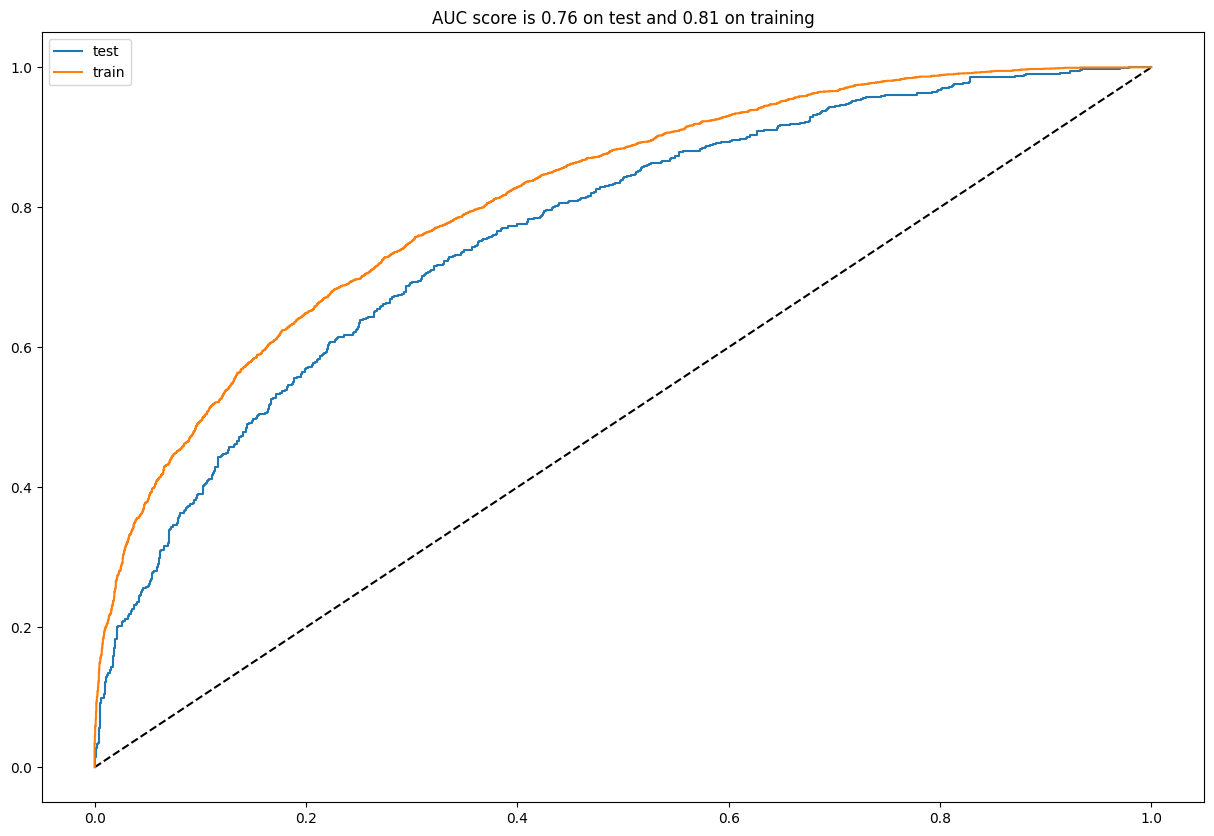

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Classification report:
               precision    recall  f1-score   support

           0       0.69      0.67      0.68       938
           1       0.70      0.72      0.71       998

    accuracy                           0.70      1936
   macro avg       0.70      0.70      0.70      1936
weighted avg       0.70      0.70      0.70      1936



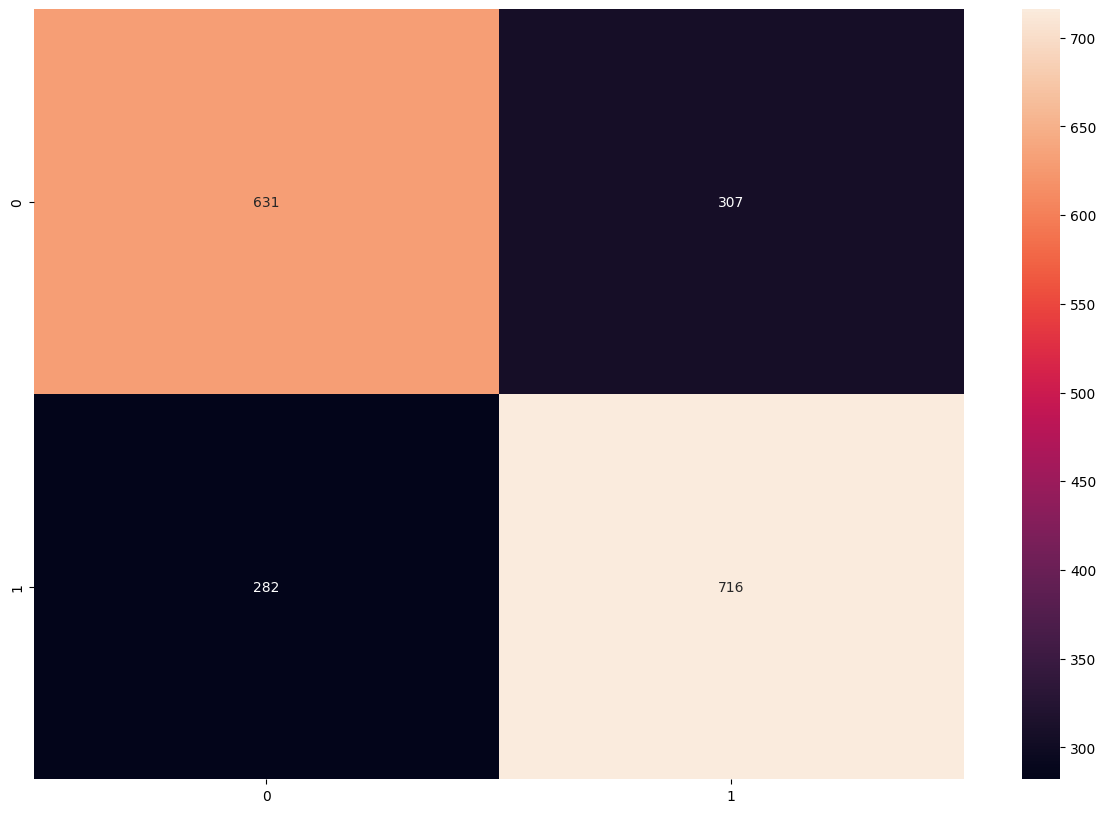

In [84]:
mlflow.sklearn.autolog(disable=True)
analyze(gb)

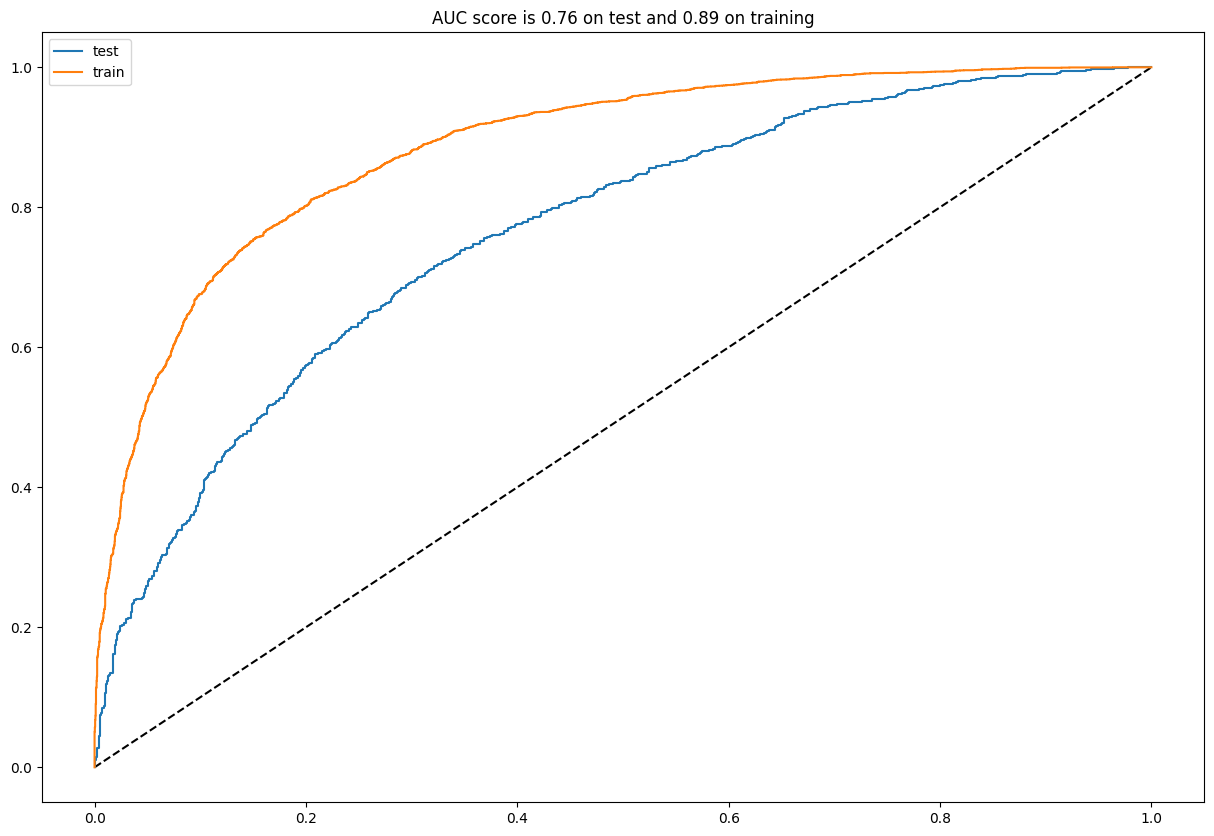

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Classification report:
               precision    recall  f1-score   support

           0       0.69      0.68      0.69       938
           1       0.70      0.71      0.71       998

    accuracy                           0.70      1936
   macro avg       0.70      0.70      0.70      1936
weighted avg       0.70      0.70      0.70      1936



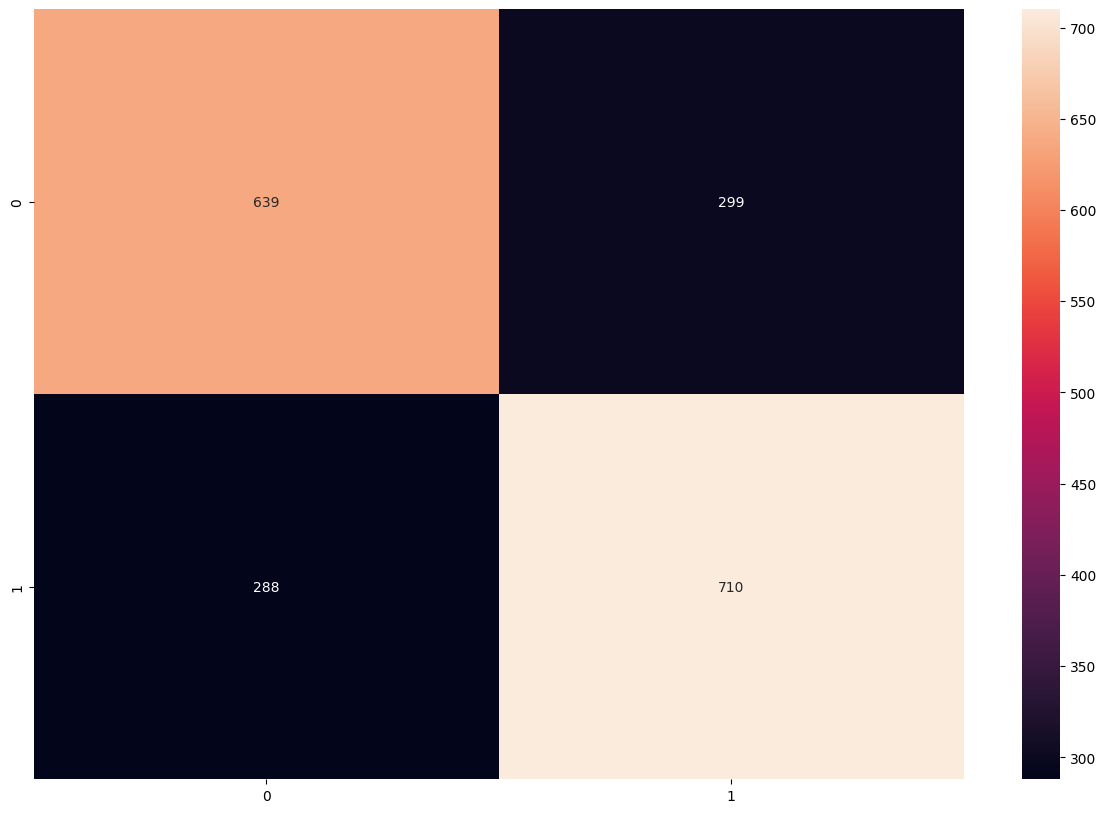

In [85]:
mlflow.sklearn.autolog(disable=True)
analyze(rf)

Le modèle Random Forest est un peu meilleur mais semble sous-ajusté. Nous allons donc utiliser le modèle Gradient Boosting.

# Gradient Boosting
Le boosting est une méthode de conversion des apprenants faibles en apprenants forts. Dans le boosting, chaque nouvel arbre correspond à une version modifiée de l'ensemble de données d'origine. L'algorithme d'amplification de gradient (gbm) peut être expliqué plus facilement en introduisant d'abord l'algorithme AdaBoost.

L'algorithme AdaBoost commence par former un arbre de décision dans lequel chaque observation se voit attribuer un poids égal. Après avoir évalué le premier arbre, nous augmentons les poids des observations difficiles à classer et diminuons les poids de celles qui sont faciles à classer. Le deuxième arbre est donc développé sur ces données pondérées. Ici, l'idée est d'améliorer les prédictions du premier arbre. Notre nouveau modèle est donc Arbre 1 + Arbre 2. Nous calculons ensuite l'erreur de classification à partir de ce nouveau modèle d'ensemble à 2 arbres et développons un troisième arbre pour prédire les résidus révisés. Nous répétons ce processus pour un nombre spécifié d'itérations. Les arbres suivants nous aident à classer les observations qui ne sont pas bien classées par les arbres précédents. Les prédictions du modèle d'ensemble final sont donc la somme pondérée des prédictions faites par les modèles d'arbres précédents.

Gradient Boosting entraîne de nombreux modèles de manière progressive, additive et séquentielle. La principale différence entre AdaBoost et Gradient Boosting Algorithm est la façon dont les deux algorithmes identifient les lacunes des apprenants faibles (par exemple, les arbres de décision). Alors que le modèle AdaBoost identifie les lacunes en utilisant des points de données à poids élevé, l'amplification de gradient effectue la même chose en utilisant des gradients dans la fonction de perte (y=ax+b+e , e nécessite une mention spéciale car il s'agit du terme d'erreur). La fonction de perte est une mesure indiquant dans quelle mesure les coefficients du modèle sont adaptés aux données sous-jacentes. Une compréhension logique de la fonction de perte dépendrait de ce que nous essayons d'optimiser.

# WC Simulation

In [115]:
# Fonction pour prédire le gagnant et la probabilité de victoire
def predict_winner_and_probability(home_team, away_team, model, team_stats_raw):
    # Cette fonction prend en entrée le nom de l'équipe (team_name) pour laquelle nous voulons trouver des statistiques.
    def find_stats(team_name):
        # Sélectionner tous les jeux passés de l'équipe spécifiée, triés par date.
        past_games = team_stats_raw[(team_stats_raw["team"] == team_name)].sort_values("date")
        # Sélectionner les cinq derniers jeux de l'équipe spécifiée, triés par date.
        last5 = team_stats_raw[(team_stats_raw["team"] == team_name)].sort_values("date").tail(5)
       # Extraire les statistiques pertinentes de l'équipe spécifiée.
        team_rank = past_games["rank"].values[-1]  # Classement actuel de l'équipe.
        team_goals = past_games.score.mean()        # Moyenne des buts marqués par l'équipe dans tous les jeux passés.
        team_goals_l5 = last5.score.mean()          # Moyenne des buts marqués par l'équipe dans les cinq derniers jeux.
        team_goals_suf = past_games.suf_score.mean()  # Moyenne des buts encaissés par l'équipe dans tous les jeux passés.
        team_goals_suf_l5 = last5.suf_score.mean()    # Moyenne des buts encaissés par l'équipe dans les cinq derniers jeux.
        team_rank_suf = past_games.rank_suf.mean()    # Moyenne du classement de l'opposition dans tous les jeux passés.
        team_rank_suf_l5 = last5.rank_suf.mean()      # Moyenne du classement de l'opposition dans les cinq derniers jeux.
        team_gp_rank = past_games.points_by_rank.mean()  # Moyenne des points par classement dans tous les jeux passés.
        team_gp_rank_l5 = last5.points_by_rank.mean()    # Moyenne des points par classement dans les cinq derniers jeux.

        # Retourner une liste contenant toutes les statistiques extraites.
        return [team_rank, team_goals, team_goals_l5, team_goals_suf, team_goals_suf_l5,
                team_rank_suf, team_rank_suf_l5, team_gp_rank, team_gp_rank_l5]

    def find_features(team_1, team_2):
        # Calculer la différence entre les classements des deux équipes.
        rank_dif = team_1[0] - team_2[0]

        # Calculer la différence entre les moyennes de buts marqués par les deux équipes.
        goals_dif = team_1[1] - team_2[1]
       
        # Calculer la différence entre les moyennes de buts marqués par les deux équipes dans les cinq derniers jeux.
        goals_dif_l5 = team_1[2] - team_2[2]

        # Calculer la différence entre les moyennes de buts encaissés par les deux équipes.
        goals_suf_dif = team_1[3] - team_2[3]

        # Calculer la différence entre les moyennes de buts encaissés par les deux équipes dans les cinq derniers jeux.
        goals_suf_dif_l5 = team_1[4] - team_2[4]

        # Calculer la différence entre le ratio buts marqués/classement pour les deux équipes.
        goals_per_ranking_dif = (team_1[1] / team_1[5]) - (team_2[1] / team_2[5])
        
        # Calculer la différence entre les classements moyens de l'opposition pour les deux équipes.
        dif_rank_agst = team_1[5] - team_2[5]

        # Calculer la différence entre les classements moyens de l'opposition dans les cinq derniers jeux pour les deux équipes.
        dif_rank_agst_l5 = team_1[6] - team_2[6]

        # Calculer la différence entre les moyennes de points par classement pour les deux équipes.
        dif_gp_rank = team_1[7] - team_2[7]

        # Calculer la différence entre les moyennes de points par classement dans les cinq derniers jeux pour les deux équipes.
        dif_gp_rank_l5 = team_1[8] - team_2[8]

        return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif,
                dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

    
    team_1 = find_stats(home_team)
    team_2 = find_stats(away_team)

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = model.predict_proba([features_g1])
    probs_g2 = model.predict_proba([features_g2])

    home_team_prob = (probs_g1[0][0] + probs_g2[0][1]) / 2
    away_team_prob = (probs_g2[0][0] + probs_g1[0][1]) / 2

    # Calculer la différence entre les probabilités ajustées
    probability_difference = abs(home_team_prob - away_team_prob)

    if probability_difference < 0.1:
        winner = "Match nul"
        winner_prob=(home_team_prob+away_team_prob)/2
    elif home_team_prob < away_team_prob:
        winner = away_team
        winner_prob = away_team_prob
    else:
        winner = home_team
        winner_prob = home_team_prob

    return winner, winner_prob

In [120]:
home_team = "Morocco"
away_team = "Algeria"

winner, probability = predict_winner_and_probability(home_team, away_team, gb, team_stats_raw)

if winner == "Match nul":
    print(f"Le match entre {home_team} et {away_team} se termine par un match nul avec une probabilité de {probability:.2f}")
else:
    print(f"Le gagnant du match entre {home_team} et {away_team} est {winner} avec une probabilité de {probability:.2f}")

Le match entre Morocco et Algeria se termine par un match nul avec une probabilité de 0.50


In [ ]:
#Reading Pandas Dataframe from mlflow
all_experiments = [exp.experiment_id for exp in mlflow.search_experiments()]
df_mlflow = mlflow.search_runs(experiment_ids=all_experiments,filter_string="metrics.F1_score_test <1")
run_id = df_mlflow.loc[df_mlflow['metrics.F1_score_test'].idxmax()]['run_id']
print(run_id)

In [ ]:
df_mlflow

In [ ]:
#let's call the model from the model registry ( in production stage)
import mlflow.pyfunc

logged_model = f'runs:/{run_id}/ML_models'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
print(loaded_model)

# Predict on a Pandas DataFrame.

loaded_model.predict(X_test)